# Main anaysis

### Setup

#### Imports

In [130]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

#### Overrides

In [131]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma='log10(0.5)'",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_gamma='np.log(0.5)'",
    "simulation.dynamics.max_its=200", # important to specify maxits
    "seed=0",
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Helper function to filter data by config data

In [132]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    imprecise_imitation_gamma = df["imprecise_imitation_gamma"].isin([curve_metadata.meaning_dist_gamma, np.nan]) # allows curve, and constraints to be the same as curve.

    # TODO: subset by max its in simulation
    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan])# allows curve

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & imprecise_imitation_gamma & max_its]

    return df_subsetted

#### Load data

In [133]:
all_data_fp = "../../analysis_data/all_data.csv"
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_24092/1048885480.py:2: DtypeWarning: Columns (15,16,18) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,seed,max_its,sender_delta,receiver_delta,min_epsilon,min_beta,eu_gamma,kl_eb,min_gnid,gnid_beta
0,1.526090e+00,1.270097,0.641931,2.278652,[0.0054146544510602634],0.012748,1.095495,0.0,simulation,NaN,...,6.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000e+00,0.000000,1.912028,16.399997,NaN,NaN,NaN,1.0,trajectory,0.0,...,6.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000e+00,0.000000,1.912028,16.330831,NaN,NaN,NaN,1.0,trajectory,1.0,...,6.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000e+00,0.000000,1.912028,16.278492,NaN,NaN,NaN,1.0,trajectory,2.0,...,6.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8.881784e-16,0.000000,1.912028,16.236625,NaN,NaN,NaN,1.0,trajectory,3.0,...,6.0,200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116703,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116704,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116705,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116706,6.643856e+00,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df[df["meaning_dist_gamma"] == 'log10(0.5)'].discriminative_need_gamma.unique()

array(['log10(0.5)', nan], dtype=object)

#### Filter

In [135]:
df = get_df_subsetted_by_meaning_dists(df, config)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,seed,max_its,sender_delta,receiver_delta,min_epsilon,min_beta,eu_gamma,kl_eb,min_gnid,gnid_beta
108290,3.981537,3.742879,33.825082,6.676706,NaN,NaN,NaN,0.0,simulation,NaN,...,0.0,200.0,0.043402,0.024557,0.000147,1.409548,0.363084,0.038614,0.000712,1.409548
108291,0.281837,0.072019,3.237316,1673.603978,NaN,NaN,NaN,1.0,trajectory,1.0,...,0.0,200.0,43.023221,43.462927,0.209522,1.001313,0.024890,0.370218,0.944756,1.000808
108292,0.091903,0.076678,3.248361,1653.467901,NaN,NaN,NaN,1.0,trajectory,2.0,...,0.0,200.0,20.009398,19.947432,0.015153,1.001010,0.027373,0.005171,0.820083,1.000758
108293,0.234585,0.213366,3.344316,1615.406959,NaN,NaN,NaN,1.0,trajectory,3.0,...,0.0,200.0,34.011236,33.129984,0.020984,1.001263,0.032470,0.003612,0.713312,1.000859
108294,0.660793,0.620029,3.645964,1476.241051,NaN,NaN,NaN,1.0,trajectory,4.0,...,0.0,200.0,52.244225,46.617872,0.039769,1.002727,0.051353,0.006150,0.647634,1.001162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116703,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116704,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116705,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116706,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
df[df["meaning_dist_gamma"] == 'log10(0.5)'].discriminative_need_gamma.value_counts()

discriminative_need_gamma
log10(0.5)    193
Name: count, dtype: int64

todo: missing data might be because max_its gets overwritten, we don't actually organize folders hierarchically with it (maybe we should). So for now just plan on running all of those sims.

In [137]:
# Edge cases where discriminative_need_gamma and meaning_dist_gamma are str types
for col in [
    "discriminative_need_gamma",
    "meaning_dist_gamma",
    "imprecise_imitation_gamma",
]:
    df[col].replace("log10(0.5)", np.log10(0.5), inplace=True)
    df[col] = df[col].astype(float)

Separate out observations into curves and simulation points

In [138]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Transform log params

In [139]:
df_final_points["discriminative_need_gamma"] = 10 ** df_final_points["discriminative_need_gamma"]
df_final_points["imprecise_imitation_gamma"] = 10 ** df_final_points["imprecise_imitation_gamma"]

Restrict dynamics

In [140]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [141]:
df_final_points.discriminative_need_gamma.unique()

array([0.5])

In [142]:
# How does seed range?
df_final_points.seed.unique()

array([0.])

In [143]:
# Remember, popuation_init_gamma is nan if we go with the simple uniform sampling init
df_final_points.population_init_gamma.unique()

array([nan])

### Visualize

In [144]:
# Make sure complexity max is np.log2(100)
assert np.allclose(df_ib_bound.complexity.max().item(), np.log2(100))

#### First visualize all data, across initializations and seeds

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


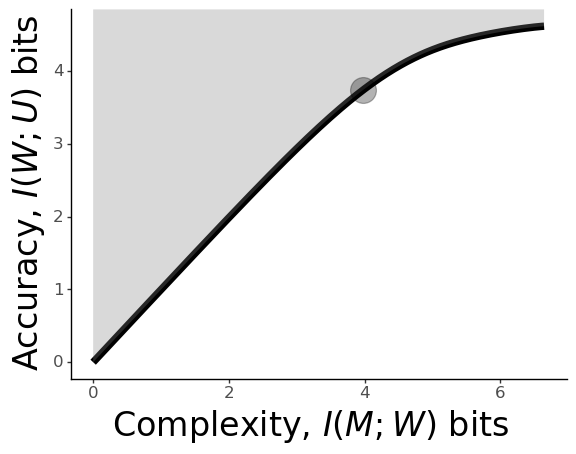

In [145]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # shape="seed",
            ),
        alpha=0.3,
        size=10,
    )
    + pn.labs(fill="$\\gamma$ (pragmatic precision)")
    # + pn.labs(fill="$\\alpha$ (perceptual certainty)")    
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.31),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 
)
print(plot)

#### Hack: mock viridis

In [146]:
# https://waldyrious.net/viridis-palette-generator/
fill_values_dict = {
    str(k): v for k, v in {
        "0.001": "#440154",
        "0.01": "#46327e",
        "0.1": "#365c8d",
        "0.5": "#277f8e",
        "1.0": "#1fa187",
        "10.0": "#4ac16d",
        "100.0" : "#a0da39",
        "1000.0": "#fde725", 
    }.items() }

In [147]:
# Double check no min_epsilons are negative
df_final_points[df_final_points.min_epsilon < 0]

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,seed,max_its,sender_delta,receiver_delta,min_epsilon,min_beta,eu_gamma,kl_eb,min_gnid,gnid_beta


#### Distribution of efficiency loss across converged emergent systems

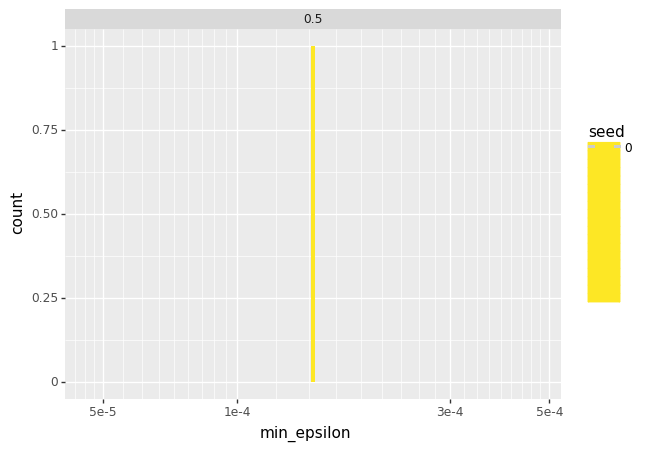

<ggplot: (343369488)>

In [148]:
df_final_points_disc = df_final_points.copy()
df_final_points_disc["discriminative_need_gamma"] = df_final_points_disc["discriminative_need_gamma"].astype(str)


(
    pn.ggplot(
        df_final_points_disc,
        pn.aes(
            x="min_epsilon",
            fill="seed",
        )
    )
    # + pn.scale_fill_manual(values = fill_values_dict)
    # + pn.geom_density()
    + pn.geom_histogram(binwidth=0.01)
    + pn.scale_x_log10()
    + pn.facet_wrap("discriminative_need_gamma")
)

# Okay, so for the first random seed I picked, the distribution of efficiency loss is highly peaked. This makes some sense, because if we look at the the trajectories, all colors appear to converge to the same respective points on y-axis.

#### Trajectories of efficiency loss

Filter

In [149]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["round"]

df_traj_analysis = df_traj_points.copy()

df_traj_analysis = df_traj_analysis[["iteration", "min_distance_to_curve", "min_epsilon", "min_beta", gamma, "population_init_gamma", "complexity", "accuracy", "seed", "kl_eb", "eu_gamma", "min_gnid", "gnid_beta"]]

# seed shoud be discrete
df_traj_analysis["seed"] = df_traj_analysis["seed"].astype(int).astype(str)

df_traj_analysis[gamma] = 10 ** df_traj_analysis[gamma]
df_traj_analysis["population_init_gamma"] = 10 ** df_traj_analysis["population_init_gamma"]

df_traj_analysis["discriminative_need_gamma"] = df_traj_analysis["discriminative_need_gamma"].astype(str)

df_traj_analysis

,iteration,min_distance_to_curve,min_epsilon,min_beta,discriminative_need_gamma,population_init_gamma,complexity,accuracy,seed,kl_eb,eu_gamma,min_gnid,gnid_beta
108291,1.0,0.148785,0.209522,1.001313,0.5,NaN,0.281837,0.072019,0,0.370218,0.024890,0.944756,1.000808
108292,2.0,0.014427,0.015153,1.001010,0.5,NaN,0.091903,0.076678,0,0.005171,0.027373,0.820083,1.000758
108293,3.0,0.016752,0.020984,1.001263,0.5,NaN,0.234585,0.213366,0,0.003612,0.032470,0.713312,1.000859
108294,4.0,0.028231,0.039769,1.002727,0.5,NaN,0.660793,0.620029,0,0.006150,0.051353,0.647634,1.001162
108295,5.0,0.050302,0.070610,1.013333,0.5,NaN,1.638070,1.559920,0,0.016552,0.113380,0.468598,1.003838
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108477,195.0,0.006771,0.000147,1.409548,0.5,NaN,3.981529,3.742872,0,0.038615,0.363082,0.000711,1.409548
108478,197.0,0.006775,0.000147,1.409548,0.5,NaN,3.981532,3.742875,0,0.038614,0.363083,0.000712,1.409548
108479,198.0,0.006777,0.000147,1.409548,0.5,NaN,3.981534,3.742876,0,0.038614,0.363083,0.000712,1.409548
108480,199.0,0.006779,0.000147,1.409548,0.5,NaN,3.981535,3.742877,0,0.038614,0.363083,0.000712,1.409548


In [150]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

200.0

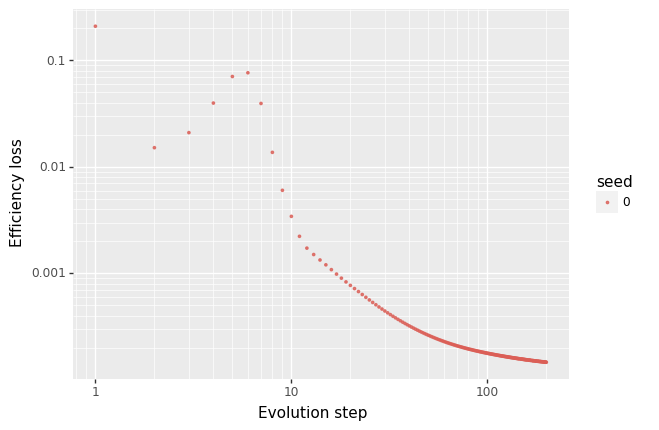

In [151]:
plot = (
    pn.ggplot(
        df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == '0.5'],
        # df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
            # color="discriminative_need_gamma",
            color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    # + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

#### Visualize comp vs. EU

In [152]:
# TODO

#### Visualize kl_eb over time

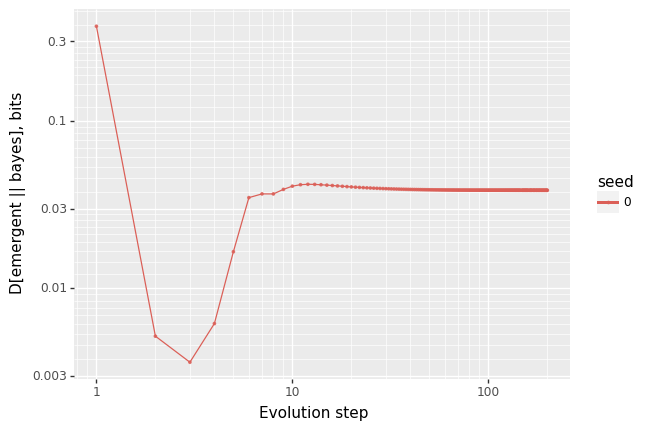

In [153]:
plot = (
    pn.ggplot(
        df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == '0.5'],
        # df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="kl_eb", 
            # color="discriminative_need_gamma",
            color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("D[emergent || bayes], bits")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

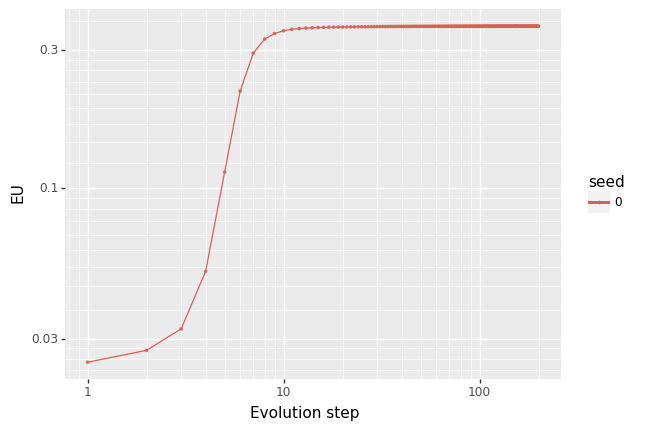

In [154]:
plot = (
    pn.ggplot(
        df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == '0.5'],
        # df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="eu_gamma", 
            # color="discriminative_need_gamma",
            color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("EU")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

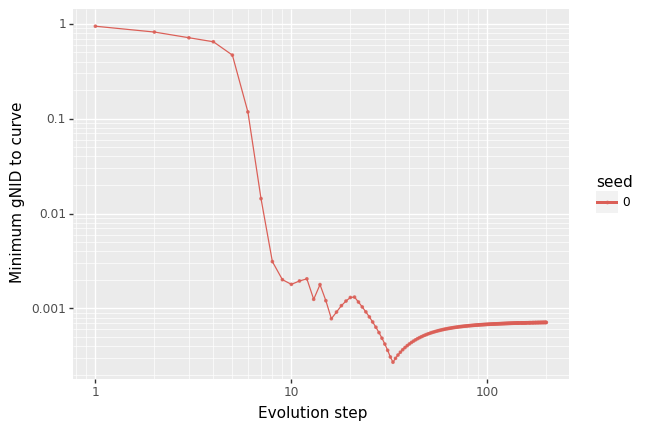

In [155]:
plot = (
    pn.ggplot(
        df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == '0.5'],
        # df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_gnid", 
            # color="discriminative_need_gamma",
            color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("Minimum gNID to curve")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)

In [ ]:
plot = (
    pn.ggplot(
        df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == '0.5'],
        # df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="gnid_beta", 
            # color="discriminative_need_gamma",
            color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        size=0.5,
        alpha=0.8,
        )
    + pn.geom_line()
    # + pn.scale_color_manual(values = fill_values_dict)
    # + pn.labs(color="$\\gamma$ (pragmatic precision)")    
    + pn.xlab("Evolution step")
    + pn.ylab("beta fitted by min_gnid")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    # + pn.scale_color_continuous(trans = 'log10')
    + pn.scale_x_log10()
    # + pn.facet_grid("population_init_gamma ~ discriminative_need_gamma")
    # + pn.facet_wrap("population_init_gamma")
)
print(plot)